In [2]:
import torch
import matplotlib.pyplot as plt
import non_local_boxes
import numpy as np
from IPython.display import clear_output   # in order to clear the print output
import time

# Sugar coating for reloading
%matplotlib inline
%load_ext autoreload
%autoreload 2

# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')   # in ordert to have unblurred pictures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Gradient Descent

In [3]:
M1 = torch.zeros(32, 32)
for i in range(32):
    M1[i,i]=1
M1[0,0]=0.5
M1[0,1]=0.5
M1[1,0]=0.5
M1[1,1]=0.5

M2 = torch.zeros(32, 32)
for i in range(32):
    M2[i,i]=1
M2[8,8]=0.5
M2[8,9]=0.5
M2[9,8]=0.5
M2[9,9]=0.5

M3 = torch.zeros(32, 32)
for i in range(32):
    M3[i,i]=1
M3[2,2]=0.5
M3[2,3]=0.5
M3[3,2]=0.5
M3[3,3]=0.5

M4 = torch.zeros(32, 32)
for i in range(32):
    M4[i,i]=1
M4[10,10]=0.5
M4[10,11]=0.5
M4[11,10]=0.5
M4[11,11]=0.5

M5 = torch.zeros(32, 32)
for i in range(32):
    M5[i,i]=1
M5[4,4]=0.5
M5[4,5]=0.5
M5[5,4]=0.5
M5[5,5]=0.5

M6 = torch.zeros(32, 32)
for i in range(32):
    M6[i,i]=1
M6[12,12]=0.5
M6[12,13]=0.5
M6[13,12]=0.5
M6[13,13]=0.5

M7 = torch.zeros(32, 32)
for i in range(32):
    M7[i,i]=1
M7[6,6]=0.5
M7[6,7]=0.5
M7[7,6]=0.5
M7[7,7]=0.5

M8 = torch.zeros(32, 32)
for i in range(32):
    M8[i,i]=1
M8[14,14]=0.5
M8[14,15]=0.5
M8[15,14]=0.5
M8[15,15]=0.5

In [4]:
def projected_wiring(W):  # W is a 32xn tensor
    W = torch.maximum(W, torch.zeros_like(W))  # it outputs the element-wise maximum
    W = torch.minimum(W, torch.ones_like(W))   # similarly for minimum

    T1 = (torch.abs(W[0,:]-W[1,:]) <= torch.abs(W[8, :] - W[9, :]))
    W = T1*torch.tensordot(M1, W, dims=1) + torch.logical_not(T1)*torch.tensordot(M2, W, dims=1)
    
    T2 = (torch.abs(W[2,:]-W[3,:]) <= torch.abs(W[10, :] - W[11, :]))
    W = T2*torch.tensordot(M3, W, dims=1) + torch.logical_not(T2)*torch.tensordot(M4, W, dims=1)

    T3 = (torch.abs(W[4,:]-W[5,:]) <= torch.abs(W[12, :] - W[13, :]))
    W = T3*torch.tensordot(M5, W, dims=1) + torch.logical_not(T3)*torch.tensordot(M6, W, dims=1)

    T4 = (torch.abs(W[6,:]-W[7,:]) <= torch.abs(W[14, :] - W[15, :]))
    W = T4*torch.tensordot(M7, W, dims=1) + torch.logical_not(T4)*torch.tensordot(M8, W, dims=1)

    return W

In [5]:
def gradient_descent(starting_W, P, Q, learning_rate = 2, nb_iterations = 40, tolerance=1e-6):
    external_grad = torch.ones(non_local_boxes.evaluate.nb_columns)
    W = starting_W
    for i in range(nb_iterations):
        W_old = W
        non_local_boxes.evaluate.phi_flat(W, P, Q).backward(gradient=external_grad)
        grad = W.grad
        W = projected_wiring(W + learning_rate*grad).detach()  # create a brand new tensor, forgeting the previous gradient
        if (torch.norm(grad) <= tolerance):   return W
        W.requires_grad=True
    return W

# Draw segment

In [6]:
def is_in_a_blue_cone_1D(value, blue_points): # It tests if Box located at (x, y) is in the cone of a blue box
    # list is a list of coordinates (x0, y0) such that h(P)<0.91 but P is blue
    for point_value in blue_points:
        if value>=point_value:
            return True
    return False

In [7]:
def new_color_1D(value, valueP, threshold, blue_points, k, max_box_power_GD, W):
    if value > threshold:
        blue_points.append(valueP)
        if W!= "No wiring":
            print(non_local_boxes.utils.projection_to_extremal_wiring(W).detach())
        return blue_points, (0, 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD), 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD))
    return blue_points, "orangered"

In [8]:
def next_Q_1D(Q, P, W0, color_point, k, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, valueP): # Q is a 2x2x2x2 tensor
    if color_point == "orangered":
        W = gradient_descent(W0, non_local_boxes.utils.tensor_to_matrix(Q), P, learning_rate, nb_iterations)
        list = non_local_boxes.evaluate.phi_flat(W, non_local_boxes.utils.tensor_to_matrix(Q), P).detach().numpy()
        index, value = max(enumerate(list), key=lambda x: x[1])  # find the best value in list
        best_wiring = W[:,index].detach()
        best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
        new_Q = non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        blue_points, color_point = new_color_1D(value, valueP, threshold, blue_points, k, max_box_power_GD, best_wiring[:,0])
        #print(value)
        best_wiring.requires_grad = True
    else:
        new_Q = Q
        best_wiring = W0
    return new_Q, best_wiring, blue_points, color_point

In [9]:
def test_box_power_1D(Q, P, W0, n, color_point, k, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, valueP): # Q is a 2x2x2x2 tensor
    Q = torch.clone(Q)
    for l in range(max_box_power):
        if color_point != "orangered":
            break
        Q=non_local_boxes.evaluate.R(W0, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        value = float(non_local_boxes.evaluate.h_flat(Q))
        blue_points, color_point = new_color_1D(value, valueP, threshold, blue_points, k, max_box_power_GD, W0[:,0])

    return blue_points, color_point

In [10]:
def draw_segment_with_rerun(Box1, Box1_name, Box2, Box2_name, box_grid_size, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, rerun_count): # P is a 4x4 tensor
    n = non_local_boxes.evaluate.nb_columns
    blue_points = []

    if n != 10000:
        return "WARNING: please change the number of wirings to 10,000."
    
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)
    
    for run in range(rerun_count):
        #clear_output()
        print(" ----- Run number ", run)
        for i in range(box_grid_size+1):
            alpha = i/box_grid_size
            xP, yP = X[0,0]*alpha + X[1,0]*(1-alpha), X[0,1]*alpha + X[1,1]*(1-alpha)
            P = alpha*Box1 + (1-alpha)*Box2   # P is a 4x4 matrix
            color_point = "orangered"

            Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
            valueP = float(non_local_boxes.evaluate.h_flat(Q))
            value = valueP
            #print(value)
            blue_points, color_point = new_color_1D(value, valueP, threshold, blue_points, 0, max_box_power_GD, "No wiring")
            best_wiring = non_local_boxes.utils.random_wiring(n)

            if is_in_a_blue_cone_1D(value, blue_points):
                color_point = (0, 0.1, 0.1)
            else:
                for k in range(max_box_power_GD-1):
                    Q, best_wiring, blue_points, color_point = next_Q_1D(Q, P, best_wiring, color_point, k+1, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, valueP)
                    blue_points, color_point = test_box_power_1D(Q, P, best_wiring, n, color_point, k+1, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, valueP)

            plt.plot(xP, yP, 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.show()

# Let's go

In [11]:
PR = non_local_boxes.utils.PR
PL = non_local_boxes.utils.P_L
PNL = non_local_boxes.utils.P_NL

 ----- Run number  0
tensor([1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0.])
 ----- Run number  1
 ----- Run number  2
tensor([1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1.])
 ----- Run number  3
 ----- Run number  4


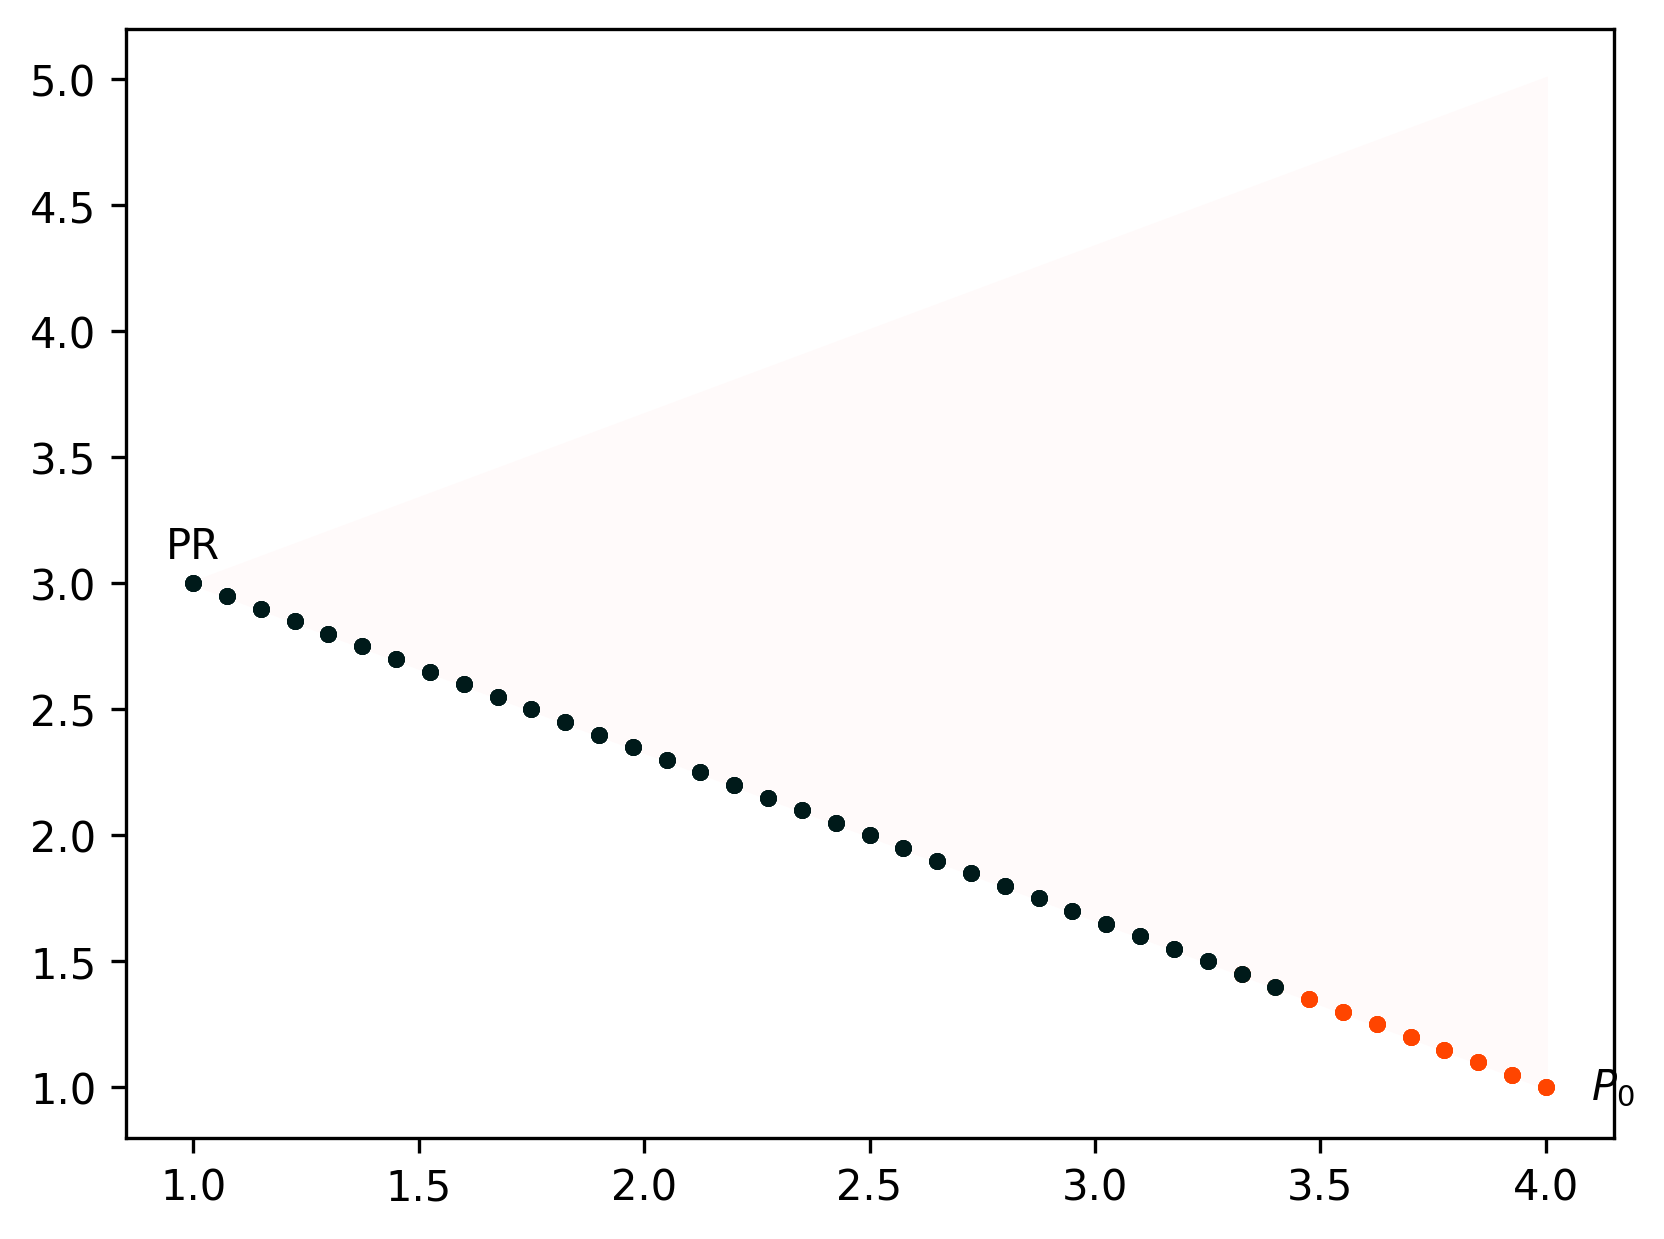

In [15]:
# Set the number of wirings to 10 000 in evaluate.py

draw_segment_with_rerun(
    Box1=PR,
    Box1_name = "PR",
    Box2=PL(0,0,0,0),
    Box2_name = "$P_0$",
    box_grid_size = 40,   # 40
    max_box_power_GD = 2,  #10
    max_box_power = 35,  # 35
    learning_rate = 2,   # 2
    nb_iterations = 50,  #40
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6,
    rerun_count = 5
)

---
---
---
---
---
---
---
---

Use `Test-Wiring.ipynb` in order to test the wiring in different triangles.